# Analysis code

Code for stats + figures.

Run this notebook from the `scripts` folder. Before running, ensure all default
values have been populated with `./scripts/update_param_list_in_model_yaml.sh`.

## Preamble (always run)

In [1]:
# for plotting
%matplotlib inline

In [2]:
# imports
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import pingouin as pg
import statsmodels as sm
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt

sns.set_theme('paper', font_scale=2)

from exp_utils import *

## ZeroSpeech libriABX analysis

In [3]:
# load zrc data
dfz = collate_data()
dfz.head(10)

,zrc.subset,zrc.speaker_mode,zrc.context_mode,zrc.granularity,zrc.score,zrc.pooling,zrc.seed,zrc.pca_style,name,feat_type,...,training.cpc_loss.averaging_penalty,training.best_rq_loss.mask_prob,training.best_rq_loss.mask_width,training.best_rq_loss.codebook_size,training.best_rq_loss.codebook_dim,training.best_rq_loss.offset,training.best_rq_loss.speaker_regex,training.best_rq_loss.prediction_type,training.shuffle,training.max_epochs
0,dev-clean,within,within,triphone,0.2104,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
1,dev-clean,across,within,triphone,0.3394,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
2,dev-other,within,within,triphone,0.2340,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
3,dev-other,across,within,triphone,0.3841,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
4,test-clean,within,within,triphone,0.2138,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
5,test-clean,across,within,triphone,0.3396,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
6,test-other,within,within,triphone,0.2522,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
7,test-other,across,within,triphone,0.3912,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
8,dev-clean,within,within,phoneme,0.1645,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
9,dev-clean,across,within,phoneme,0.2801,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200


In [4]:
# determine significance of context windows

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.cpc_loss.prediction_steps": 12,
    "training.cpc_loss.gutted_steps": 0,
    "training.cpc_loss.negative_samples": 128,
    "training.loss_type": "cpc",
    "zrc.granularity": "phoneme",
    'training.cpc_loss.averaging_penalty': 0,
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "zrc.speaker_mode": "within",
})
df = filter_data_in(
    df, {"csa.max_width": range(2, 65)}
)
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score",
    "zrc.context_mode", "training.cpc_loss.offset"
)

# 6 seeds * 6 context widths * 2 context modes * 4 partitions
assert len(df) == 6 * 6 * 2 * 4

df = df[['name', 'csa.max_width', 'zrc.score']].groupby('name', as_index=False, observed=True, sort=True).mean(numeric_only=True)
df['csa.max_width'] = df['csa.max_width'].astype('int').astype('category')

pg.print_table(pg.anova(data=df, dv='zrc.score', between='csa.max_width'))
pg.print_table(pg.normality(data=df, dv='zrc.score', group='csa.max_width'))
pg.print_table(pg.homoscedasticity(data=df, dv='zrc.score', group='csa.max_width'))

pg.print_table(pg.pairwise_tests(data=df, dv='zrc.score', between='csa.max_width', parametric=False, return_desc=True))



ANOVA SUMMARY

Source           ddof1    ddof2      F    p-unc    np2
-------------  -------  -------  -----  -------  -----
csa.max_width        5       30  4.652    0.003  0.437

    W    pval  normal
-----  ------  --------
0.864   0.202  True
0.983   0.966  True
0.794   0.052  True
0.856   0.175  True
0.967   0.874  True
0.806   0.066  True

    W    pval  equal_var
-----  ------  -----------
1.046   0.410  True


POST HOC TESTS

Contrast         A    B    mean(A)    std(A)    mean(B)    std(B)  Paired    Parametric      U-val  alternative      p-unc    hedges
-------------  ---  ---  ---------  --------  ---------  --------  --------  ------------  -------  -------------  -------  --------
csa.max_width    2    4      0.141     0.013      0.133     0.012  False     False          26.000  two-sided        0.240     0.592
csa.max_width    2    8      0.141     0.013      0.137     0.017  False     False          20.000  two-sided        0.818     0.242
csa.max_width    2   16      

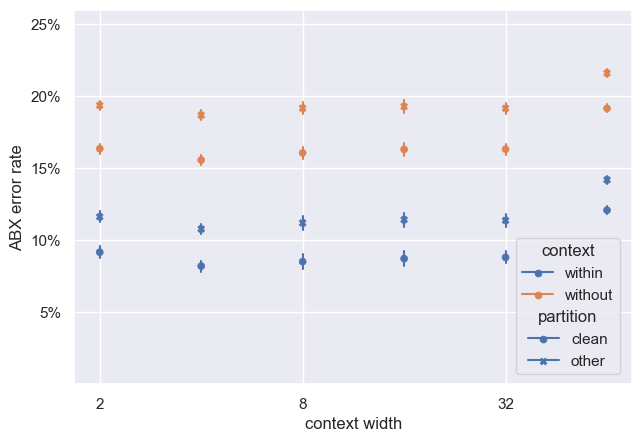

In [5]:
# plot libriABX scores across subsets and context windows w/ phoneme granularity

fig = plt.figure(1, figsize=[6.8, 4.8])
# # cpc.small results
# df = filter_data_equal(dfz, {
#     'name': 'cpc.small/version_2',
#     "zrc.pca_style": "full",
#     "zrc.speaker_mode": "within",
#     "zrc.granularity": "phoneme",
# }).copy()
# df['zrc.subset'] = df['zrc.subset'].map(
#     {
#         'test-clean': 'clean',
#         'test-other': 'other',
#         'dev-clean': 'clean',
#         'dev-other': 'other'}
# )
# df['zrc.context_mode'] = df['zrc.context_mode'].map({'within': 'within', 'any': 'without'})
# df = (
#     df[['zrc.context_mode', 'zrc.subset', 'zrc.score']]
#     .groupby(['zrc.context_mode', 'zrc.subset']).mean()
# )
# ax.axhline(y=df.loc[('within', 'clean'), 'zrc.score'], color=sns.color_palette()[0], linestyle='--', alpha=0.75)
# ax.axhline(y=df.loc[('without', 'clean'), 'zrc.score'], color=sns.color_palette()[1], linestyle='--', alpha=0.75)

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.cpc_loss.prediction_steps": 12,
    "training.cpc_loss.gutted_steps": 0,
    "training.cpc_loss.negative_samples": 128,
    "training.loss_type": "cpc",
    "zrc.granularity": "phoneme",
    'training.cpc_loss.averaging_penalty': 0,
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "zrc.speaker_mode": "within",
})
# we filter for versions < 200 b/c the versions >= 200, which are meant to replicate
# this matrix, are only sporadically complete atm. This way, we stick with one
# repetition 
df = filter_data_in(
    df, {"csa.max_width": range(2, 65), "version": range(200)}
)
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score",
    "zrc.context_mode", "training.cpc_loss.offset"
)

# 6 seeds * 6 context widths * 2 context modes * 4 partitions
assert len(df) == 6 * 6 * 2 * 4

# aggregate dev and test into their quality
df['zrc.subset'] = df['zrc.subset'].map(
    {
        'test-clean': 'clean',
        'test-other': 'other',
        'dev-clean': 'clean',
        'dev-other': 'other'}
)
df['zrc.context_mode'] = df['zrc.context_mode'].map({'within': 'within', 'any': 'without'})

# ensure each point in a vertical slice gets its own error bar
df['zrc.sbyc'] = df.agg("{0[zrc.subset]}-{0[zrc.context_mode]}".format, axis=1)

plot = (
    so.Plot(df, x="csa.max_width", y="zrc.score", color="zrc.context_mode", marker="zrc.subset")
    .limit(y=(0.00, 0.26))
    .add(so.Dot(pointsize=5), so.Agg())
    .add(so.Range(), so.Est(errorbar="se"), group='zrc.sbyc')  # 1 standard error
    # .add(so.Line(marker=None), so.PolyFit())  # misleading?
    .scale(
        x=(
            so.Continuous(trans="log")
            .tick(at=[2, 8, 32, 128])
            .label(like='d', base=2)
        ),
        y=(
            so.Continuous()
            .tick(at=[0.05, 0.1, 0.15, 0.2, 0.25])
            .label(like='.0%')
        ),
    )
    .label(x="context width", y="ABX error rate", color="context", marker="partition")
    .on(fig)
)

plot.plot()

leg = fig.legends[0]
bb = leg.get_bbox_to_anchor().transformed(fig.axes[0].transAxes.inverted())
bb.x0 -= .325
bb.y0 -= .725
leg.set_bbox_to_anchor(bb, transform=fig.axes[0].transAxes)

fig.tight_layout()
fig.savefig('../resources/libriabx_context_subset_phoneme.pdf')

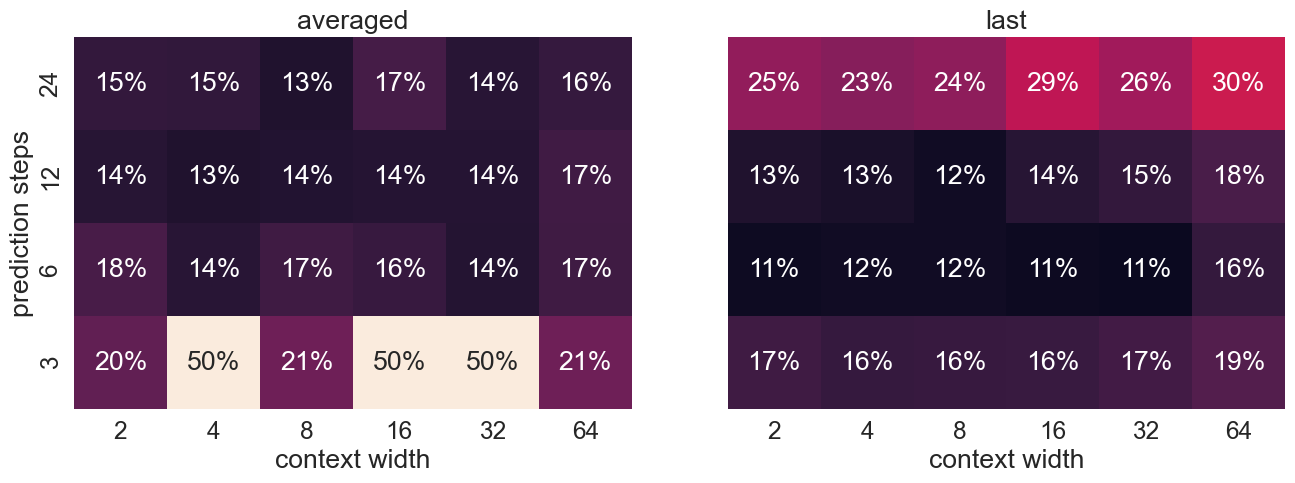

In [6]:
# plot libriABX score of context width vs prediction steps (averaged)
# - this one will show up on the left of our figure, so it doesn't have the cbar
#   but does have the y axis label
fig, axs = plt.subplots(1, 2, figsize=(14, 4.8), sharey=True)

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    "training.cpc_loss.gutted_steps": 0,
    'training.cpc_loss.averaging_penalty': 0,
    "zrc.granularity": "phoneme",
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "zrc.speaker_mode": "within",
})
df = filter_data_in(
    df, {
        "csa.max_width": range(2, 65),
        "training.cpc_loss.prediction_steps": range(2, 25),
        "version": range(200)
    }
)
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score",
    "zrc.context_mode", "training.cpc_loss.offset",
    "training.cpc_loss.prediction_steps",
    "training.cpc_loss.negative_samples",
)
df = df.pivot_table(
    columns="csa.max_width",
    index="training.cpc_loss.prediction_steps",
    values="zrc.score"
).sort_values(by='training.cpc_loss.prediction_steps', ascending=False)
plot = sns.heatmap(df, annot=True, fmt=".0%", vmin=0.1, vmax=0.5, cbar=False, square=True, ax=axs[0])
plot.set(xlabel='context width', ylabel='prediction steps', title='averaged')
plot.set_xticklabels([f'{int(x):d}' for x in sorted(df.columns)])

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    'training.cpc_loss.averaging_penalty': 0,
    "training.cpc_loss.negative_samples": 128,
    "zrc.granularity": "phoneme",
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "zrc.speaker_mode": "within",
})
df = filter_data_in(
    df, {"csa.max_width": range(2, 65), "version": range(200)}
)
idx = df['training.cpc_loss.prediction_steps'] == 1
for n in range(2, 25):
    idx |= (df['training.cpc_loss.prediction_steps'] == n) & (df['training.cpc_loss.gutted_steps'] == (n - 1))
df = df.loc[idx]
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score",
    "zrc.context_mode", "training.cpc_loss.offset",
    "training.cpc_loss.prediction_steps",
    "training.cpc_loss.gutted_steps",
)
df = df.pivot_table(
    columns="csa.max_width",
    index="training.cpc_loss.prediction_steps",
    values="zrc.score"
).sort_values(by='training.cpc_loss.prediction_steps', ascending=False)
plot = sns.heatmap(df, annot=True, fmt=".0%", vmin=0.1, vmax=0.5, square=True, cbar=False, ax=axs[1])
plot.set(xlabel='context width', ylabel=None, title='last')
plot.set_xticklabels([f'{int(x):d}' for x in sorted(df.columns)])
plot.set_yticklabels([f'{int(x):d}' for x in sorted(df.index, reverse=True)])

fig.tight_layout()
fig.savefig("../resources/libriabx_prediction_steps_vs_width.pdf")

In [11]:
# various means for stats table
# (main can be derived from the above figure)

row2names = {
    "main": {
        "cpc.trans2/version_1",
        "cpc.trans4/version_1",
        "cpc.trans8/version_2",
        "cpc.trans16/version_2",
        "cpc.trans32/version_2",
        "cpc.trans64/version_2",
    } | set(f'cpc.trans{w}/version_{v}' for w in (2, 4, 8, 16, 32) for v in range(100, 105)),
    "2-layer": {
        "cpc.trans2/version_12",
        "cpc.trans4/version_12",
        "cpc.trans8/version_14",
        "cpc.trans16/version_14",
        "cpc.trans32/version_12",
        "cpc.trans64/version_14",
    },
    "4-layer": {
        "cpc.trans2/version_11",
        "cpc.trans4/version_11",
        "cpc.trans8/version_13",
        "cpc.trans16/version_13",
        "cpc.trans32/version_13",
        "cpc.trans64/version_13",
    },
    "conv (fixed size)": {
        "cpc.cconv2/version_1",
        "cpc.cconv4/version_1",
        "cpc.cconv8/version_1",
        "cpc.cconv16/version_1",
        "cpc.cconv32/version_1",
        "cpc.cconv64/version_1",
    },
    "conv (fixed H_2)": {
        "cpc.cconv2/version_2",
        "cpc.cconv4/version_2",
        "cpc.cconv8/version_2",
        "cpc.cconv16/version_2",
        "cpc.cconv32/version_2",
        "cpc.cconv64/version_2",
    },
    "best-rq": {
        "bestrq.trans2/version_1",
        "bestrq.trans4/version_1",
        "bestrq.trans8/version_1",
        "bestrq.trans16/version_1",
        "bestrq.trans32/version_1",
        "bestrq.trans64/version_1",
    }
}
name2row = dict()
for row, names in row2names.items():
    name2row.update((name, row) for name in names)

df = filter_data_equal(dfz, {"zrc.speaker_mode": "within", "zrc.granularity": "phoneme"})
df = filter_data_in(df, {'name': set(name2row)}).copy()

df['csa.max_width'] = df['csa.max_width'].where(~df['csa.max_width'].isna(), df['cconv.kernel_size']).astype('int')

df['name'] = df['name'].cat.remove_unused_categories().apply(lambda x: name2row[x])

df = pd.pivot_table(df, values='zrc.score', columns='csa.max_width', index='name')

(df * 100).style.format(precision=1)

csa.max_width,2,4,8,16,32,64
name,,,,,,
2-layer,nan,nan,nan,14.4,16.9,nan
4-layer,11.5,13.4,15.1,12.6,15.8,19.5
best-rq,23.0,19.5,19.3,18.4,18.6,20.0
conv (fixed H_2),nan,10.8,12.6,12.3,24.9,29.0
conv (fixed size),17.3,nan,15.6,16.1,14.5,19.0
main,14.1,13.3,13.7,13.9,13.9,16.7


In [8]:
# the mean abx error rates for the models we trained downstream ASR systems for

df = filter_data_equal(dfz, {"zrc.speaker_mode": "within", "zrc.granularity": "phoneme"})
df = filter_data_in(df, {'name': {
    'cpc.trans2/version_1', 'cpc.trans4/version_1',
    'cpc.trans8/version_2', 'cpc.trans64/version_2',
}})
df['csa.max_width'] = df['csa.max_width'].astype('int')
df = pd.pivot_table(df, values='zrc.score', index='csa.max_width')
(df * 100).style.format(precision=1)

,zrc.score
csa.max_width,
2,12.5
4,11.9
8,11.5
64,16.7


## Tensorboard analysis

In [9]:
# load data
dft = collate_data("tb")
dft.head(10)

,tb.step,tb.epoch,tb.val_loss,name,feat_type,train_part,input_size,latent_type,context_type,version,...,training.cpc_loss.averaging_penalty,training.best_rq_loss.mask_prob,training.best_rq_loss.mask_width,training.best_rq_loss.codebook_size,training.best_rq_loss.codebook_dim,training.best_rq_loss.offset,training.best_rq_loss.speaker_regex,training.best_rq_loss.prediction_type,training.shuffle,training.max_epochs
0,1901,0,0.458719,bestrq.small/version_1,fbank-80,100,80,ff,recur,1,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
1,3803,1,0.340937,bestrq.small/version_1,fbank-80,100,80,ff,recur,1,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
2,5705,2,0.271982,bestrq.small/version_1,fbank-80,100,80,ff,recur,1,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
3,7607,3,0.228843,bestrq.small/version_1,fbank-80,100,80,ff,recur,1,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
4,9509,4,0.202791,bestrq.small/version_1,fbank-80,100,80,ff,recur,1,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
5,11411,5,0.189972,bestrq.small/version_1,fbank-80,100,80,ff,recur,1,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
6,13313,6,0.170144,bestrq.small/version_1,fbank-80,100,80,ff,recur,1,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
7,15215,7,0.153720,bestrq.small/version_1,fbank-80,100,80,ff,recur,1,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
8,17117,8,0.145142,bestrq.small/version_1,fbank-80,100,80,ff,recur,1,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
9,19019,9,0.149311,bestrq.small/version_1,fbank-80,100,80,ff,recur,1,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200


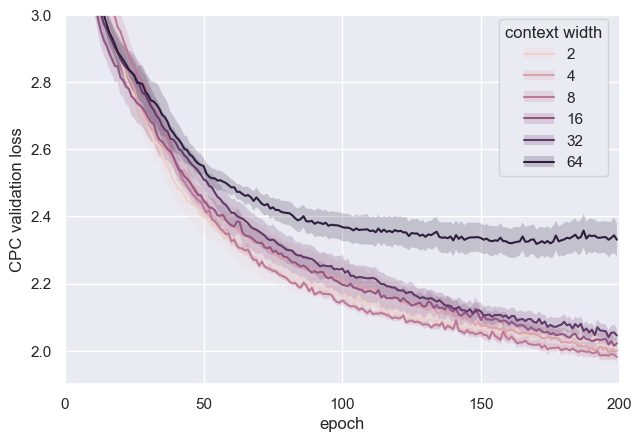

In [10]:
df = filter_data_equal(dft, {
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    "training.cpc_loss.gutted_steps": 0,
    'training.cpc_loss.averaging_penalty': 0,
    "training.cpc_loss.prediction_steps": 12,
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
})
df = filter_data_in(
    df, {"csa.max_width": range(2, 65)}
).copy()

check_data(
    df, "tb.epoch", "tb.val_loss", "tb.step", "csa.max_width", "csa.num_layers",
    "training.cpc_loss.offset"
)
# 6 seeds * 6 context windows
assert len(pd.unique(df['name'])) == 6 * 6

fig = plt.figure(1, figsize=[6.8, 4.8])
plot = (
    so.Plot(df, x="tb.epoch", y="tb.val_loss", color="csa.max_width")
    .limit(y=(1.9, 3.0), x=(0, 200))
    .add(so.Line(), so.Agg())
    .add(so.Band(), so.Est(errorbar="se"), group="csa.max_width")
    .label(x="epoch", y="CPC validation loss", color="context width")
    .scale(
        color=so.Continuous(trans="log")
            .tick(at=(2, 4, 8, 16, 32, 64))
            .label(like=".0f"))
    .on(fig)
)

plot.plot()

leg = fig.legends[0]
bb = leg.get_bbox_to_anchor().transformed(fig.axes[0].transAxes.inverted())
bb.x0 -= .335
bb.y0 += .41
leg.set_bbox_to_anchor(bb, transform=fig.axes[0].transAxes)

fig.tight_layout()
fig.savefig('../resources/train_loss_vs_width.pdf')